# UK Mobile Network Signal Data Visualisation

This generates a visualisation of 2G/3G/4G mobile signal data on UK rail lines from a dataset gathered by Ofcom.

The lovely [Datashader](https://datashader.org/) is used to render it.

The data is available on [Ofcom's open data page](https://www.ofcom.org.uk/research-and-data/data/opendata) under "Spectrum Open Data". Note that each file is around 1.5GB in size, for a total size of around 4GB.

In [1]:
import pandas as pd
import numpy as np
import datashader as ds
import datashader.transfer_functions as tf
import colorcet
from PIL import Image, ImageFont, ImageDraw
from common import draw_text, tile_images

In [3]:
%%time

# Load the data as Pandas data frames. This takes a while.
gsm = pd.read_csv('./gsm-jun18tojun19-yt.csv')
umts = pd.read_csv('./umts-jun18tojun19-yt.csv')
lte = pd.read_csv('./lte-jun18tojun19-yt.csv')

CPU times: user 38.5 s, sys: 3.58 s, total: 42.1 s
Wall time: 42.2 s


In [5]:
# Correct an apparently misnamed column in the LTE dataset.
lte['ptotal'] = lte['total_power']

In [6]:
# Fetch the boundaries and calculate the aspect ratio (Datashader doesn't do this automatically).
# We're using the OS grid coordinates provided in the data here as it's a better projection than lat/lon.

border = 50000 # 50km border
max_x, min_x = np.max(gsm['eastings']) + border, np.min(gsm['eastings']) - border
max_y, min_y = np.max(gsm['northings']) + border, np.min(gsm['northings']) - border

aspect = (max_y - min_y) / (max_x - min_x)

In [7]:
def make_plot(data):
    """ Render a single dataset and return a Datashader image. """
    width = 1000
    cvs = ds.Canvas(plot_width=width, 
                    plot_height=int(width * aspect), 
                    x_range=(min_x, max_x), 
                    y_range=(min_y, max_y))
    
    # Plot the points here, using the maximum received signal strength if we
    # have multiple measurements in one pixel.
    agg = cvs.points(data, 'eastings', 'northings', ds.max('ptotal'))
    
    # Shade using the BMY pallete from colorcet and spread the data a bit to improve visibility.
    return tf.set_background(tf.spread(tf.shade(agg, cmap=colorcet.bmy), px=1), 'black')

CPU times: user 2.23 s, sys: 654 ms, total: 2.88 s
Wall time: 3.06 s


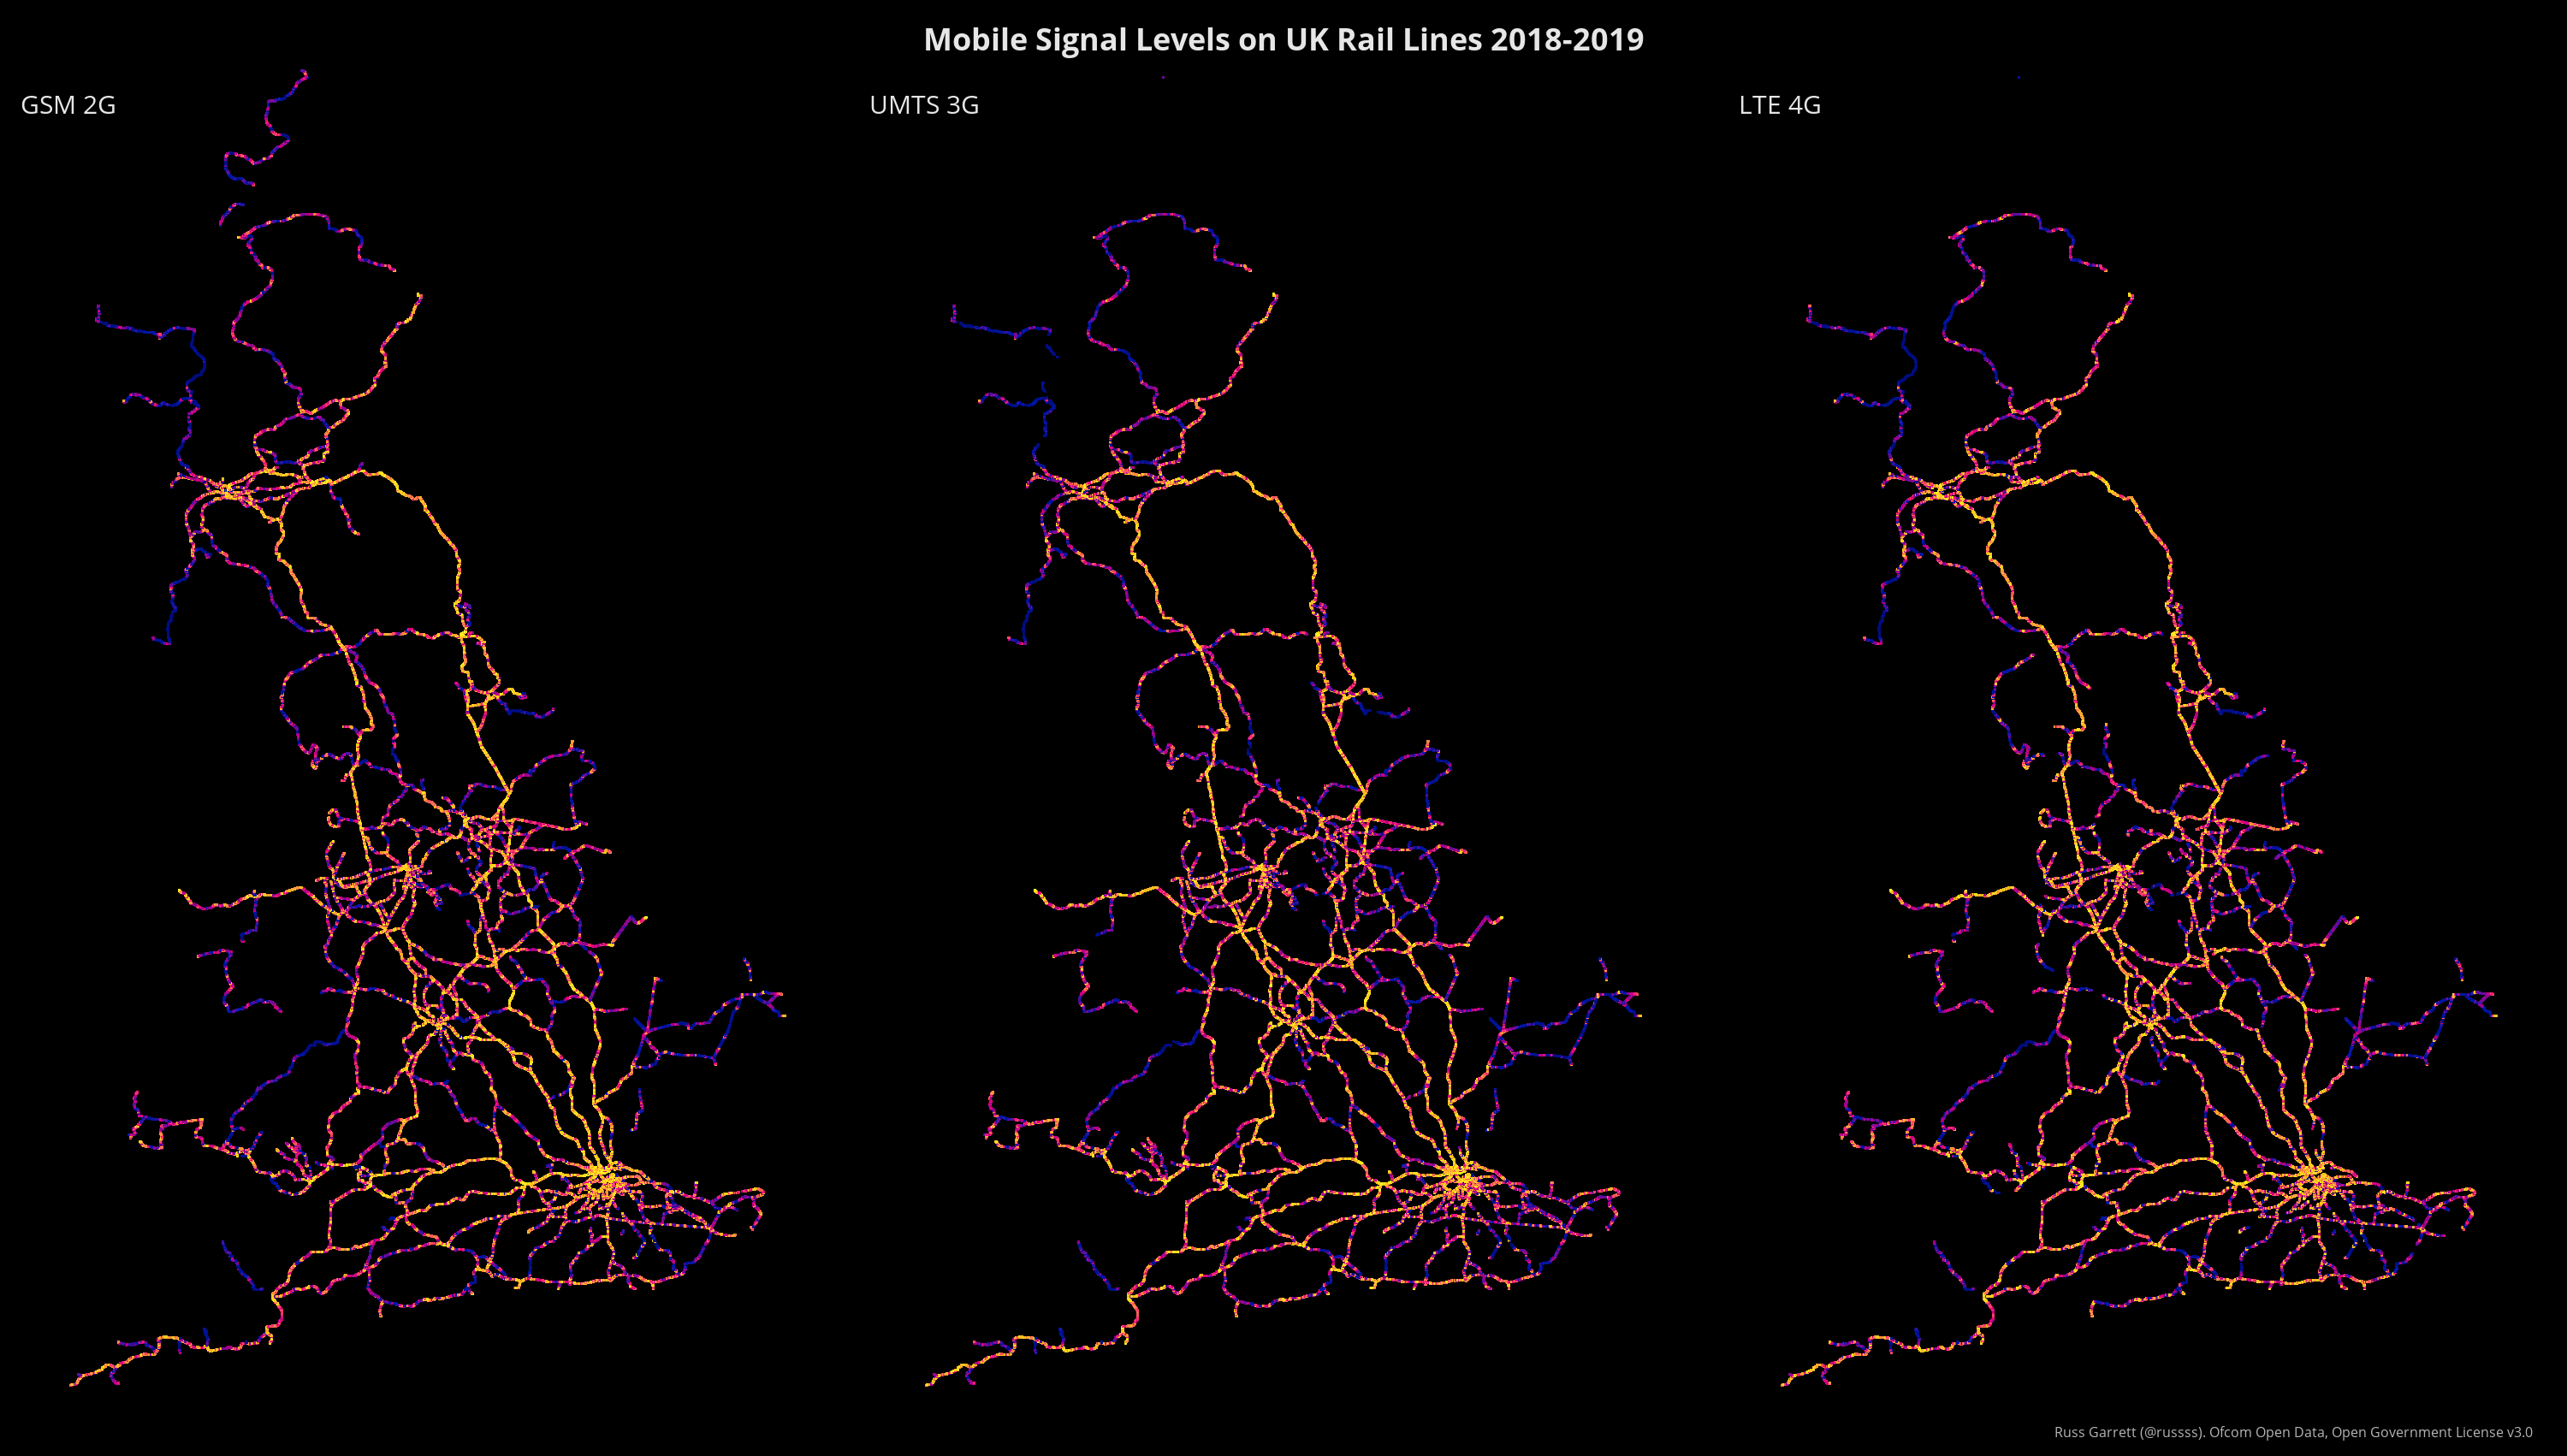

In [8]:
%%time
# Actually render the data, by technology

# Produce the three plot images and label them
images = [draw_text(make_plot(gsm).to_pil(), "GSM 2G", 80, 100), 
          draw_text(make_plot(umts).to_pil(), "UMTS 3G", 80, 100),
          draw_text(make_plot(lte).to_pil(), "LTE 4G", 80, 100)]


output = tile_images(images)
width, height = output.size

# Draw title and footer text
draw_text(output, "Mobile Signal Levels on UK Rail Lines 2018-2019", width//2, 20, size=36, face="Bold")
draw_text(output, "Russ Garrett (@russss). Ofcom Open Data, Open Government License v3.0", 
     width - 320, height - 40, size=16, color=(180,180,180))

# Save and render output
output.save('coverage_by_technology.png')
output

CPU times: user 16.9 s, sys: 9.5 s, total: 26.5 s
Wall time: 27 s


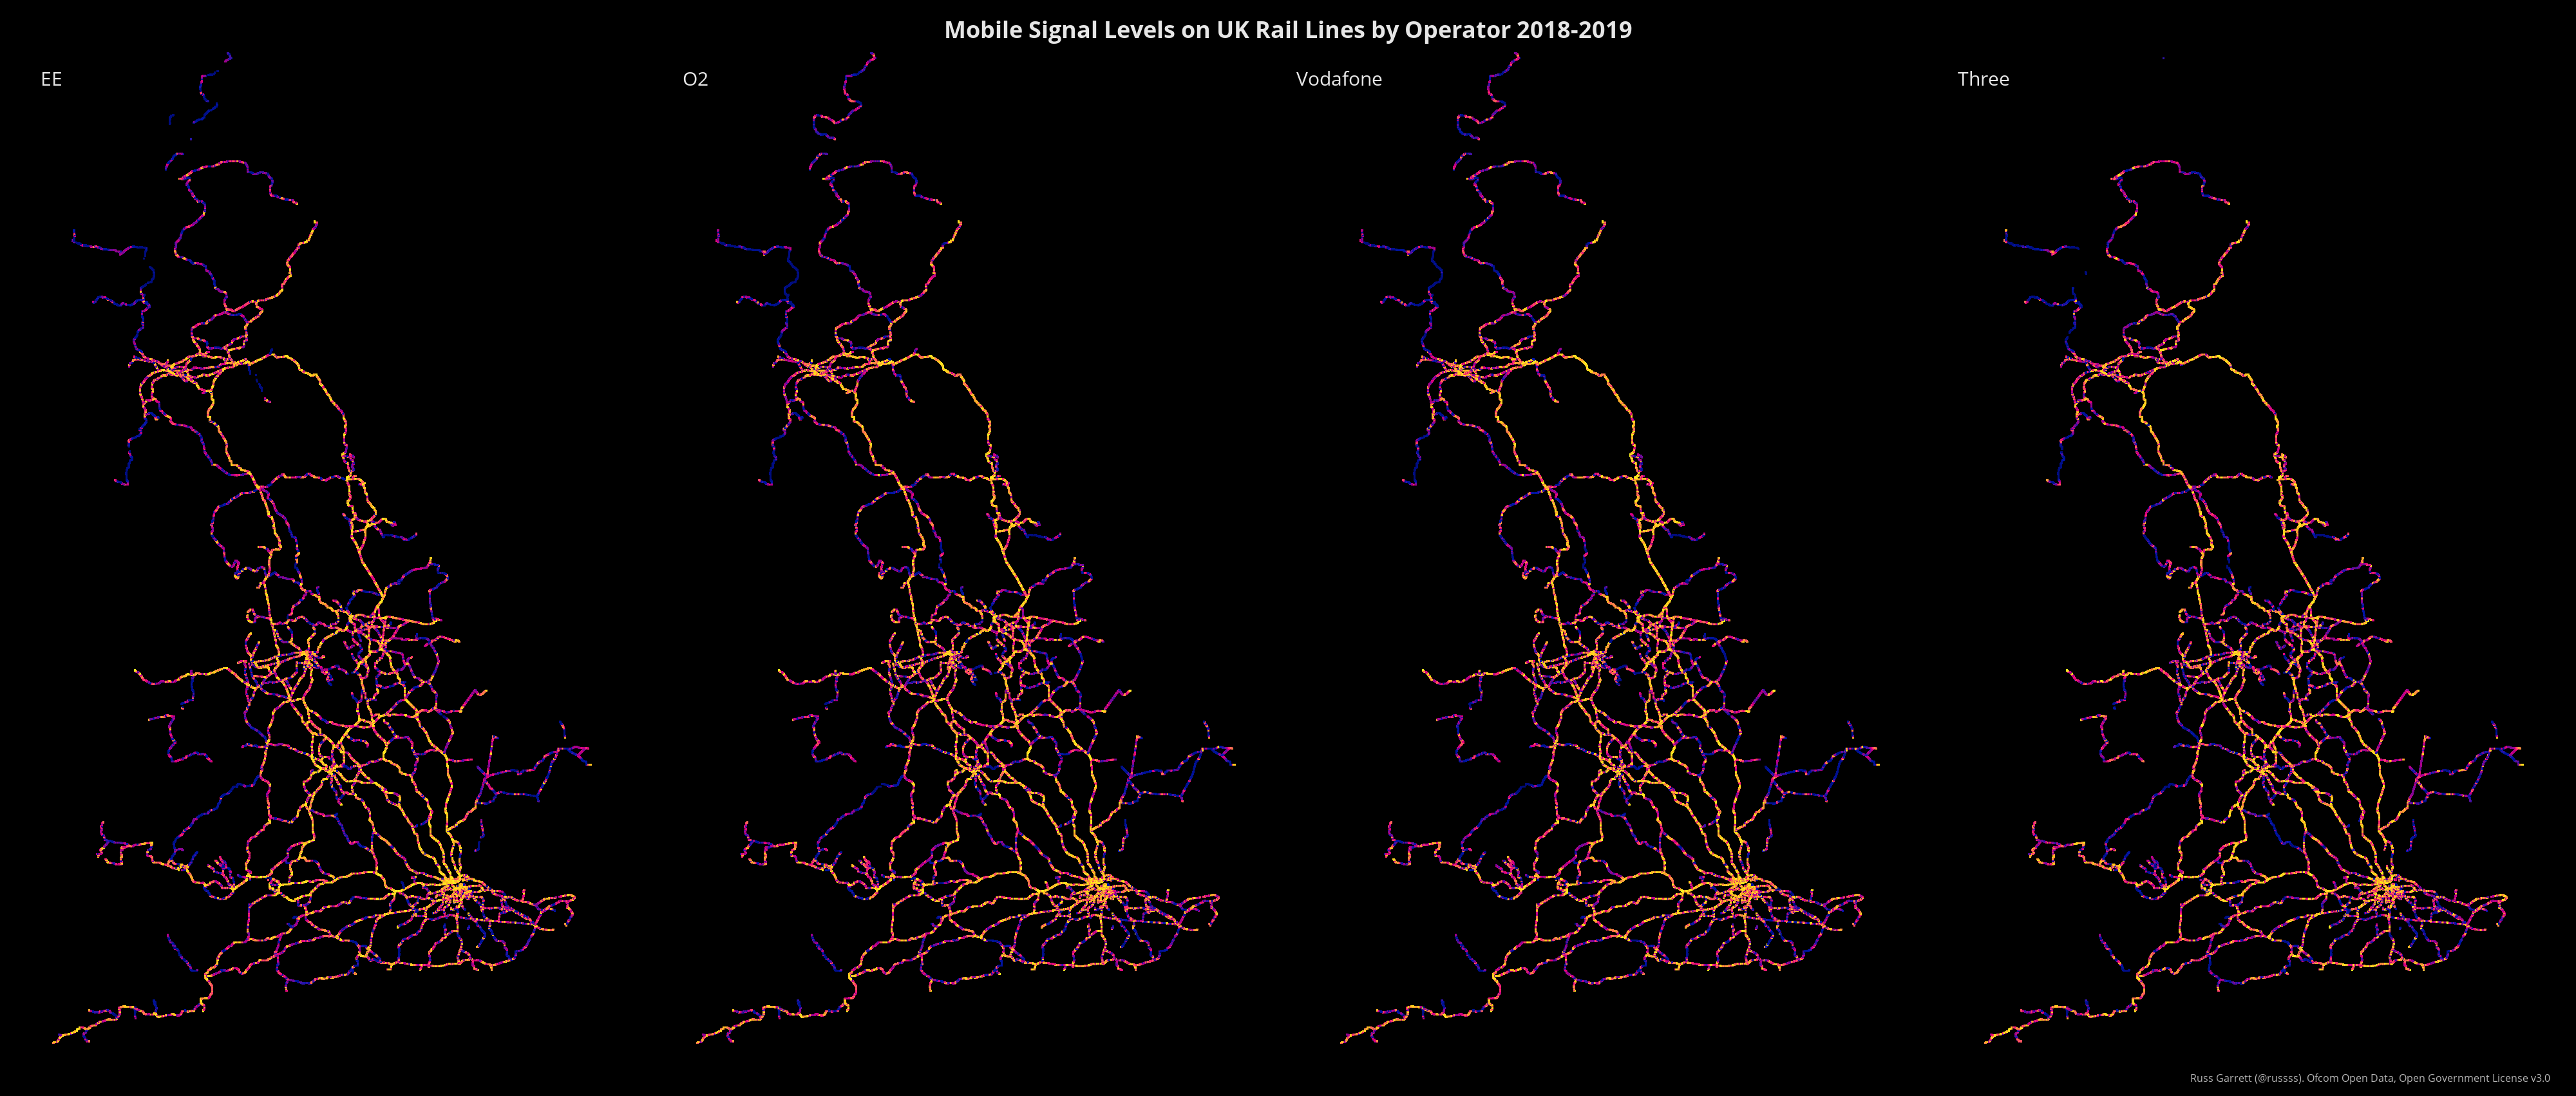

In [33]:
%%time
# Render the data by operator.
data = pd.concat((gsm, umts, lte), sort=False)

# Although the dataset has an operator column, it's only filled in for LTE.
# So work this out by MNC.
mnc = {
    'EE': [33, 30],
    'O2': [10],
    'Vodafone': [15],
    'Three': [20]
}

plots = []
for operator, mncs in mnc.items():
    plots.append(draw_text(make_plot(data[data['mnc'].isin(mncs)]).to_pil(), operator, 80, 100))
    
output = tile_images(plots)
width, height = output.size
draw_text(output, "Mobile Signal Levels on UK Rail Lines by Operator 2018-2019", width//2, 20, size=36, face="Bold")
draw_text(output, "Russ Garrett (@russss). Ofcom Open Data, Open Government License v3.0", 
     width - 320, height - 40, size=16, color=(180,180,180))
output.save('coverage_by_operator.png')
output